In [2]:
%matplotlib inline
from pathlib import Path
import numpy as np 
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import sklearn
import pandas as pd
import librosa, librosa.display
import os

In [ ]:
#Use Librosa to load audio files of songs in each genre; for now we will use just two genres to simplify
hiphop_songs = [librosa.load(p)[0] for p in Path().glob('genres/hiphop/*.au')]
classical_songs = [librosa.load(p)[0] for p in Path().glob('genres/classical/*.au')]

In [6]:
#Check to make sure files loaded under variable
len(hiphop_songs)

100

In [7]:
len(classical_songs)

100

In [8]:
#Set up Librosa to extract Zero Crossing Rate and Spectral Centroid features
def extract_features(signal):
    return [
        librosa.feature.zero_crossing_rate(signal)[0, 0],
        librosa.feature.spectral_centroid(signal)[0, 0],
    ]

In [9]:
#Extract those features from songs in Classical and Hip Hop genres and drop into arrays
classical_features = np.array([extract_features(x) for x in classical_songs])
hiphop_features = np.array([extract_features(x) for x in hiphop_songs])

## Zero Crossing Rate

Wikiepedia: The zero-crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval, being a key feature to classify percussive sounds.
https://en.wikipedia.org/wiki/Zero-crossing_rate

<img src="zerocrossing.svg"/> 

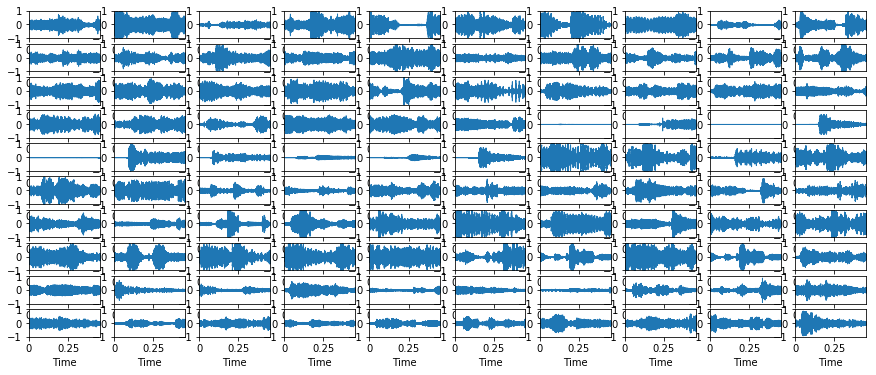

In [11]:
#Plot the Zero Crossing Rates of all the Hip Hop song snippets for a general overview of how they can differ
plt.figure(figsize=(15, 6))
for i, x in enumerate(hiphop_songs):
    plt.subplot(10, 10, i+1)
    librosa.display.waveplot(x[:10000])
    plt.ylim(-1, 1)

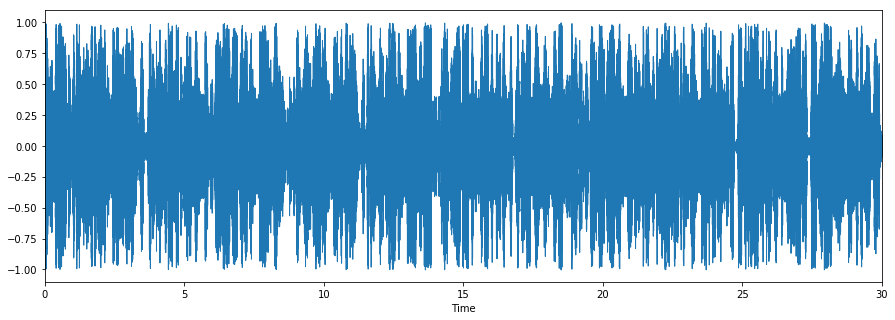

In [12]:
#Let's pick one hip hop song and look at how the Zero Crossing Rate looks on a graph
#x is the array and sr is the sampling rate of x
hiphop_song  = 'genres/hiphop/hiphop.00001.au'
x_hiphop, sr_hiphop = librosa.load(hiphop_song, duration=30)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x_hiphop, sr_hiphop)

In [13]:
#Play song audio clip
ipd.Audio(x_hiphop, rate=sr_hiphop)

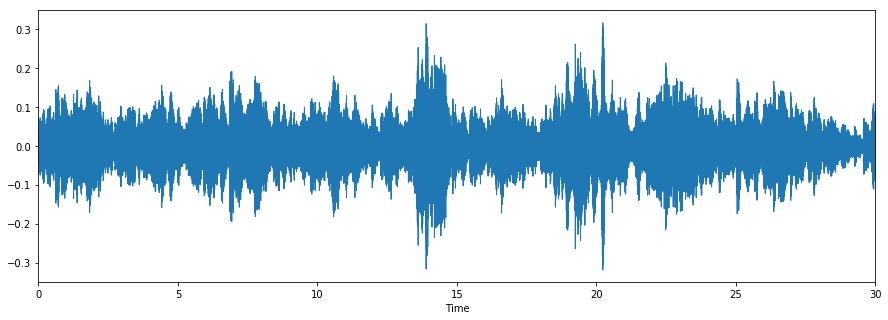

In [14]:
#Plot the ZCR of a classical song and see how it compares visually to the hip hop song
classical_song = 'genres/classical/classical.00000.au'
x_classical, sr_classical = librosa.load(classical_song, duration=30)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x_classical, sr_classical)

In [15]:
#Play audio clip
ipd.Audio(x_classical, rate=sr_classical)

## Spectral Centroid

Wikipedia: The spectral centroid is a measure used in digital signal processing to characterise a spectrum. It indicates where the "center of mass" of the spectrum is located. Perceptually, it has a robust connection with the impression of "brightness" of a sound.
https://en.wikipedia.org/wiki/Spectral_centroid

<img src="centroid.svg"/>

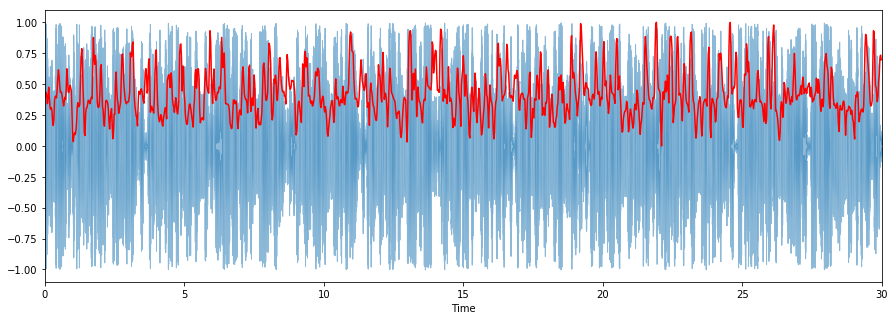

In [16]:
#Use Librosa to read the Spectral Centroid of the hip hop song
spectral_centroid_hiphop = librosa.feature.spectral_centroid(x_hiphop, sr_hiphop)[0]
frames = range(len(spectral_centroid_hiphop))
t = librosa.frames_to_time(frames)

#Normalize for visualization
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plot hip hop song Spectral Centroid on top of the ZCR waveplot
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x_hiphop, sr_hiphop, alpha=0.5)
plt.plot(t, normalize(spectral_centroid_hiphop), color='r') # normalize for visualization purposes

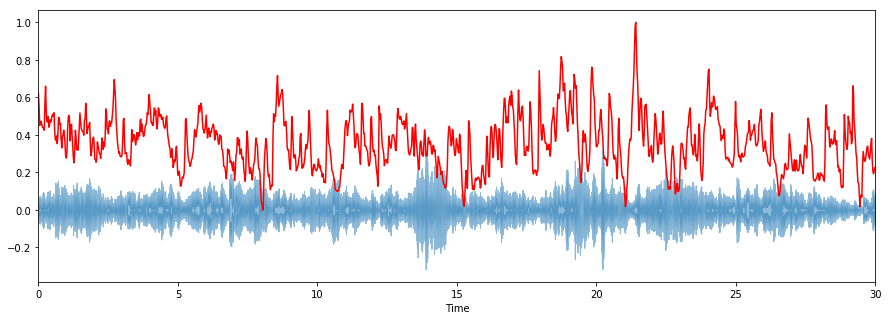

In [17]:
#Plot the classical song in the same way to compare
spectral_centroid_classical = librosa.feature.spectral_centroid(x_classical, sr_classical)[0]
frames = range(len(spectral_centroid_classical))
t = librosa.frames_to_time(frames)
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x_classical, sr_classical, alpha=0.5)
plt.plot(t, normalize(spectral_centroid_classical), color='r') # normalize for visualization purposes

In [18]:
#Put the features from Classical and Hip Hop into a single array
feature_table = np.vstack((hiphop_features, classical_features))
feature_table.shape

(200, 2)

In [19]:
#Use SKLearn MinMaxScaler to scale the training set into values between 1 and -1
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
training_features = scaler.fit_transform(feature_table)
print(training_features.min(axis=0))
print(training_features.max(axis=0))

[-1. -1.]
[1. 1.]


Text(0,0.5,'Spectral Centroid')

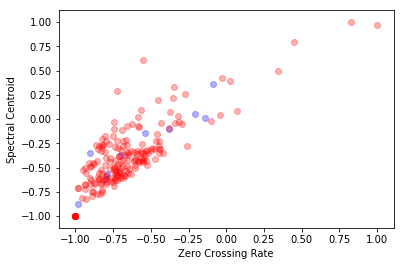

In [20]:
#Plot the ZCR and SC of each genre
plt.scatter(training_features[:10,0], training_features[:10,1], c='b', alpha=.3)
plt.scatter(training_features[10:,0], training_features[10:,1], c='r', alpha=.3)
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Spectral Centroid')

In [62]:
#Set up arrays of just the ZCR features of hip hop and classical songs; transpose index and columns
zcr_hiphop = librosa.feature.zero_crossing_rate(x_hiphop, sr_hiphop).T
zcr_classical = librosa.feature.zero_crossing_rate(x_classical, sr_classical).T

In [63]:
#Use SKLearn to scale hip hop features; fit to data and transform
scaler = sklearn.preprocessing.StandardScaler()
zcr_hiphop_scaled = scaler.fit_transform(zcr_hiphop)

In [31]:
#Mean value
zcr_hiphop_scaled.mean(axis=0)

array([-4.45464099e-16])

In [64]:
#Standard deviation
zcr_hiphop_scaled.std(axis=0)

array([1.])

In [66]:
#Scaler for classical features
zcr_classical_scaled = scaler.transform(zcr_classical)
zcr_classical_scaled.mean(axis=0)

array([0.03002766])

In [68]:
#Standard deviation
zcr_classical_scaled.std(axis=0)

array([0.39585965])

In [70]:
#Stack array vertically
features = np.vstack((zcr_hiphop_scaled, zcr_classical_scaled))
features.shape

(2584, 1)

In [71]:
#Concatenate arrays and fill with zeros for hiphop; ones for classical
labels = np.concatenate((np.zeros(len(zcr_hiphop_scaled)), np.ones(len(zcr_classical_scaled))))

In [73]:
#Set up model and fit
model = sklearn.svm.SVC()
model.fit(features, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [76]:
#Test hip hop song
x_hiphop_test, sr_hiphop = librosa.load(hiphop_song, duration=10)
x_hiphop_test.shape

(220500,)

In [77]:
x_classical_test, sr_classical = librosa.load(classical_song, duration=10)
x_classical_test.shape

(220500,)

In [86]:
#Listen to 10-second test audio clip
ipd.Audio(x_hiphop_test, rate=sr_hiphop)
#ipd.Audio(x_classical_test, rate=sr_classical)

In [81]:
#Set up test data in arrays
zcr_hiphop_test = librosa.feature.zero_crossing_rate(x_hiphop_test, sr_hiphop).T
zcr_classical_test = librosa.feature.zero_crossing_rate(x_classical_test, sr_classical).T

In [84]:
#Check shape
print(zcr_hiphop_test.shape)
print(zcr_classical_test.shape)

(431, 1)
(431, 1)


In [89]:
#Scale and transform test arrays
zcr_hiphop_test_scaled = scaler.transform(zcr_hiphop_test)
zcr_classical_test_scaled = scaler.transform(zcr_classical_test)
features_test = np.vstack((zcr_hiphop_test_scaled, zcr_classical_test_scaled))

In [90]:
#Zeros and ones in array for test data
labels_test = np.concatenate((np.zeros(len(zcr_hiphop_test)), np.ones(len(zcr_classical_test))))
predicted_labels = model.predict(features_test)

In [98]:
#Show score
score = model.score(features_test, labels_test)
score

0.7088167053364269